# Libraries

In [13]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from tensorflow.keras.regularizers import l2

**Pseudocode**
- upload data (check values)
- train test split
- processing (resize + augmentation)

# Upload data

In [2]:
neg_img_dir = '/Users/renatoboemer/signet-ring-cv/data/sig-train-neg'
pos_img_dir = '/Users/renatoboemer/signet-ring-cv/data/sig-train-pos'

In [3]:
# create a dfs
neg_images = [os.path.join(neg_img_dir, f) for f in os.listdir(neg_img_dir) if f.endswith('.jpeg')]
neg_df = pd.DataFrame(neg_images, columns=['image_path'])
neg_df['label'] = 0

pos_images = [os.path.join(pos_img_dir, f) for f in os.listdir(pos_img_dir) if f.endswith('.jpeg')]
pos_df = pd.DataFrame(pos_images, columns=['image_path'])
pos_df['label'] = 1

In [4]:
# combine dfs
df = pd.concat([pos_df, neg_df], ignore_index=True)
df.head()

,image_path,label
0,/Users/renatoboemer/signet-ring-cv/data/sig-tr...,1
1,/Users/renatoboemer/signet-ring-cv/data/sig-tr...,1
2,/Users/renatoboemer/signet-ring-cv/data/sig-tr...,1
3,/Users/renatoboemer/signet-ring-cv/data/sig-tr...,1
4,/Users/renatoboemer/signet-ring-cv/data/sig-tr...,1


In [5]:
df.groupby('label').agg({'image_path': pd.Series.nunique})

,image_path
label,
0,378
1,77


In [6]:
image_paths = pos_df['image_path'].unique()

# Train Test Split

In [7]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


## Resize, Normalise, and Augment

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def create_generator(dataframe, x_col, y_col, image_data_generator, target_size, batch_size, class_mode):
#     # Temporary DataFrame to avoid altering the original one
#     temp_df = dataframe.copy()
#     temp_df[y_col] = temp_df[y_col].astype(str)  # Convert labels to string

#     return image_data_generator.flow_from_dataframe(
#         dataframe=temp_df,
#         x_col=x_col,
#         y_col=y_col,
#         target_size=target_size,
#         batch_size=batch_size,
#         class_mode=class_mode
#     )

# # Example usage
# train_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = create_generator(
#     dataframe=train_df,
#     x_col='image_path',
#     y_col='label',
#     image_data_generator=train_datagen,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

# val_generator = create_generator(
#     dataframe=val_df,
#     x_col='image_path',
#     y_col='label',
#     image_data_generator=val_datagen,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generator(dataframe, x_col, y_col, image_data_generator, target_size, batch_size, class_mode):
    # temporary df to avoid altering the original
    temp_df = dataframe.copy()
    temp_df[y_col] = temp_df[y_col].astype(str)

    return image_data_generator.flow_from_dataframe(
        dataframe=temp_df,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

# Define data augmentation parameters for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,         # Random rotations in the range of 0-45 degrees
    width_shift_range=0.2,     # Random horizontal shifts
    height_shift_range=0.2,    # Random vertical shifts
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Random horizontal flips
    vertical_flip=True,        # Random vertical flips
    fill_mode='nearest'        # Strategy to fill newly created pixels
)

# for the validation generator, usually, we only rescale
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = create_generator(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    image_data_generator=train_datagen,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = create_generator(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    image_data_generator=val_datagen,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 273 validated image filenames belonging to 2 classes.
Found 91 validated image filenames belonging to 2 classes.


In [9]:
# class distribution
train_df['label'].value_counts()

label
0    230
1     43
Name: count, dtype: int64

# Build Model

In [18]:
# load pre-trained model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)


# define model
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
# compile
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall()])

# # get summary
# model.summary()

In [20]:
# train
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=20,
    verbose=1
)


Epoch 1/20
9/9 [==============================] - 95s 11s/step - loss: 4.8987 - accuracy: 0.8095 - recall_1: 0.0698 - val_loss: 4.0986 - val_accuracy: 0.8462 - val_recall_1: 0.0000e+00
Epoch 2/20
9/9 [==============================] - 92s 10s/step - loss: 3.6498 - accuracy: 0.8425 - recall_1: 0.0233 - val_loss: 2.9811 - val_accuracy: 0.8462 - val_recall_1: 0.0000e+00
Epoch 3/20
9/9 [==============================] - 94s 11s/step - loss: 2.6288 - accuracy: 0.8425 - recall_1: 0.0000e+00 - val_loss: 2.1591 - val_accuracy: 0.8462 - val_recall_1: 0.0000e+00
Epoch 4/20
9/9 [==============================] - 95s 11s/step - loss: 1.9145 - accuracy: 0.8535 - recall_1: 0.0930 - val_loss: 1.5785 - val_accuracy: 0.8462 - val_recall_1: 0.0000e+00
Epoch 5/20
9/9 [==============================] - 95s 11s/step - loss: 1.4210 - accuracy: 0.8462 - recall_1: 0.0233 - val_loss: 1.1804 - val_accuracy: 0.8462 - val_recall_1: 0.0000e+00
Epoch 6/20
9/9 [==============================] - 95s 11s/step - loss: 

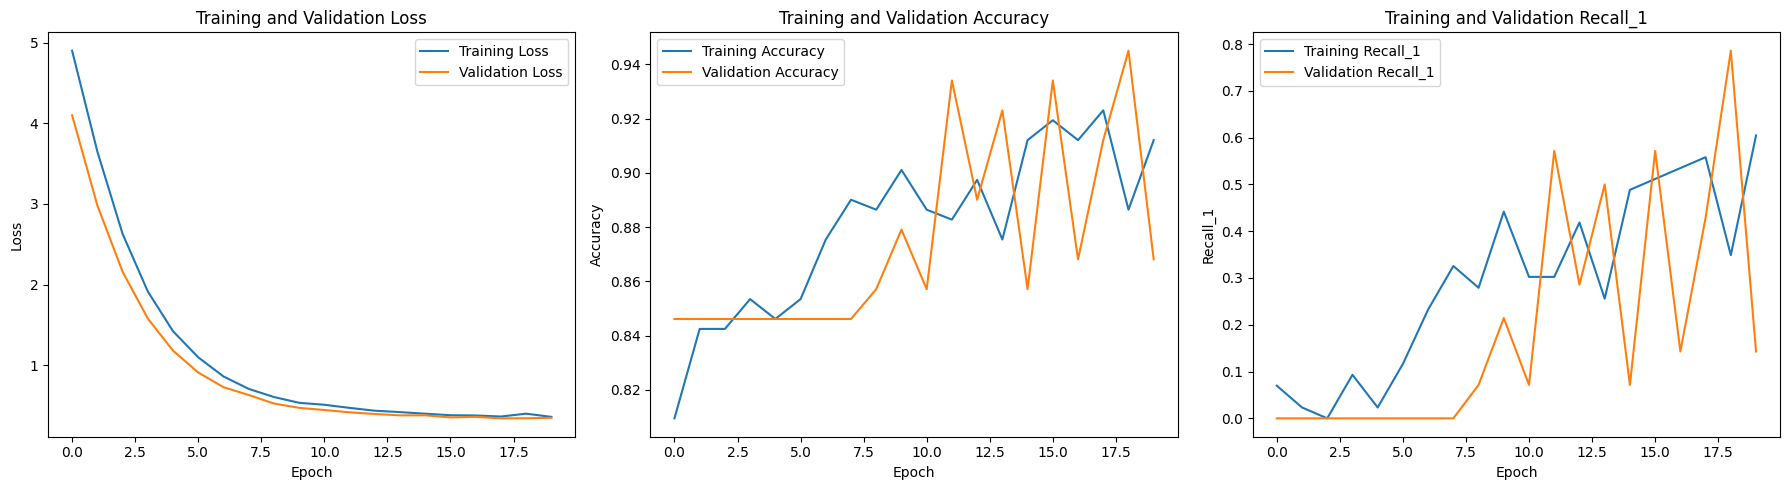

In [23]:
def plot_history(history):
    metrics = list(history.keys())
    num_metrics = len(metrics) // 2 
    plt.figure(figsize=(6 * num_metrics, 5))

    for i, metric in enumerate(metrics[:num_metrics]):
        plt.subplot(1, num_metrics, i + 1)
        plt.plot(history[metric], label=f'Training {metric.capitalize()}')
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming 'history' is the history object returned from the 'fit' function
plot_history(history.history)

# Predict

In [24]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Convert labels to string for the generator
test_df['label_str'] = test_df['label'].astype(str)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 91 validated image filenames belonging to 2 classes.


In [25]:
y_true_numeric = test_df['label'].values


In [26]:
predictions = model.predict(test_generator)

3/3 [==============================] - 22s 7s/step


# Custom Metrics

In [27]:
def calculate_FPNormal(y_true, y_pred):
    # Convert predictions and true values to boolean
    y_pred_bool = y_pred.astype(bool)
    y_true_bool = y_true.astype(bool)

    # False positives: where the true label is 0 (normal) but predicted as 1 (cancer)
    false_positives = (y_pred_bool & ~y_true_bool)

    # Count false positives in normal cases
    FPNormal = false_positives.sum() / (~y_true_bool).sum()

    return FPNormal

y_true_test = test_df['label'].values

FPNormal = calculate_FPNormal(y_true_test, predictions.round())
print("FPNormal:", FPNormal)

FPNormal: 4.0


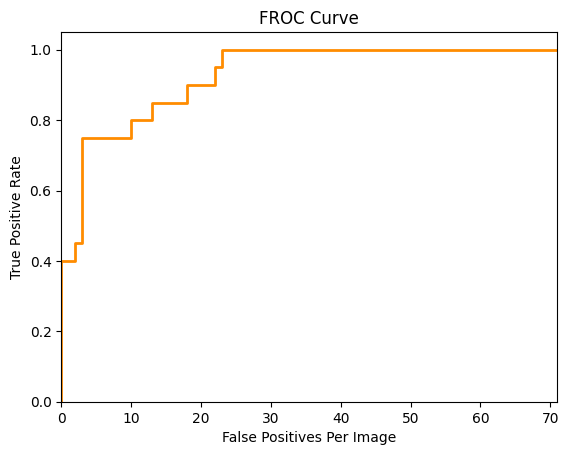

In [28]:
from sklearn.metrics import roc_curve

y_score = predictions

def calculate_FROC(y_true_test, y_score):
    # Compute ROC curve and ROC area for each threshold
    fpr, tpr, thresholds = roc_curve(y_true_test, y_score)

    # Calculate the average number of false positives per image at each threshold
    FPPI = fpr * np.sum(~y_true_test.astype(bool))  # False Positives Per Image

    # FROC is typically represented as a plot of TPR vs FPPI
    return tpr, FPPI, thresholds

# Assuming y_test contains true labels and y_score contains the raw output probabilities from the model
tpr, FPPI, thresholds = calculate_FROC(y_true_test, y_score)

# To plot the FROC curve, you can use matplotlib or any other plotting library

plt.figure()
plt.plot(FPPI, tpr, color='darkorange', lw=2)
plt.xlim([0.0, max(FPPI)])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Per Image')
plt.ylabel('True Positive Rate')
plt.title('FROC Curve');